# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint
from datetime import datetime
import scipy.stats as st

# Import API key
from config import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(len(cities))


598


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [3]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Build partial query URL
query_url = f"{url}appid={weather_api_key}&units={units}&q="


In [4]:
#Build summary dataframe
cityDF= pd.DataFrame({"City": cities,
                      "Lat": "",
                      "Lng":"",
                      "Max Temp":"",
                      "Humidity":"",
                      "Cloudiness":"",
                      "Wind Speed":"",
                      "Country":"",
                      "Date":""
                                
                               })

#uncomment this for testing smaller dataset
#cityDF = cityDF.iloc[0:300] 

# Loop through the cityDF and find all weather data for each city
print("Beginning Data Retrieval")     
print("-----------------------------")

for index, row in cityDF.iterrows():
    try:
        city = row['City']
        response = requests.get(query_url + city).json()
        cityDF.loc[index,"Lat"] = response["coord"]['lat']
        cityDF.loc[index,"Lng"] = response["coord"]['lon']
        cityDF.loc[index,"Max Temp"] = response["main"]['temp_max']
        cityDF.loc[index,"Humidity"] = response["main"]['humidity']
        cityDF.loc[index,"Cloudiness"] = response["clouds"]['all']
        cityDF.loc[index,"Wind Speed"] = response["wind"]['speed']
        cityDF.loc[index,"Country"] = response["sys"]['country']
        cityDF.loc[index,"Date"] = response["dt"]
        print("Processing Record "+str(index+1)+" of Set 1 | "+city)
        
    except KeyError:
        print("City not found..Skipping...|"+city)
    except:
        print("ERROR..Skipping...|"+city)

Beginning Data Retrieval
-----------------------------
Processing Record 1 of Set 1 | tuatapere
Processing Record 2 of Set 1 | ternate
Processing Record 3 of Set 1 | lebu
Processing Record 4 of Set 1 | ushuaia
Processing Record 5 of Set 1 | bambous virieux
Processing Record 6 of Set 1 | hermanus
Processing Record 7 of Set 1 | busselton
Processing Record 8 of Set 1 | rikitea
Processing Record 9 of Set 1 | santa maria
Processing Record 10 of Set 1 | zaragoza
Processing Record 11 of Set 1 | liberal
Processing Record 12 of Set 1 | bluff
Processing Record 13 of Set 1 | albany
Processing Record 14 of Set 1 | kruisfontein
Processing Record 15 of Set 1 | sahuaripa
Processing Record 16 of Set 1 | nanuque
Processing Record 17 of Set 1 | tuktoyaktuk
Processing Record 18 of Set 1 | chokurdakh
Processing Record 19 of Set 1 | yerbogachen
Processing Record 20 of Set 1 | pismo beach
Processing Record 21 of Set 1 | bulawayo
Processing Record 22 of Set 1 | punta arenas
Processing Record 23 of Set 1 | qa

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
cityDF.to_csv(output_data_file,index=False)
cityDF.head(100)

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,tuatapere,-46.1333,167.683,57,93,55,7,NZ,1613320997
1,ternate,0.8,127.4,81.34,78,99,8.63,ID,1613320998
2,lebu,-37.6167,-73.65,62.89,63,9,17.9,CL,1613320998
3,ushuaia,-54.8,-68.3,48.2,49,75,5.75,AR,1613320708
4,bambous virieux,-20.3428,57.7575,80.6,78,20,5.48,MU,1613320871
...,...,...,...,...,...,...,...,...,...
95,hamilton,39.1834,-84.5333,26.01,68,90,10.36,US,1613320912
96,fort nelson,58.8053,-122.7,-22,69,20,3.44,CA,1613320988
97,vaini,-21.2,-175.2,79.68,84,46,11.56,TO,1613321007
98,port alfred,-33.5906,26.891,75,91,47,5.01,ZA,1613320847


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [6]:
HumidityOutliers = []

for index, row in cityDF.iterrows():
    if cityDF.loc[index,"Humidity"] != "":
        if cityDF.loc[index,"Humidity"] > 100:
            HumidityOutliers.append(index)


In [7]:
#  Get the indices of cities that have humidity over 100%.
print("Indices with humidity over 100%")
print(HumidityOutliers )

Indices with humidity over 100%
[]


In [8]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_data = cityDF.drop(HumidityOutliers, inplace=False)

#also drop cities where no data was found
clean_city_data = clean_city_data[clean_city_data['Lat'] != ""]

#reset index
clean_city_data = clean_city_data.reset_index()
#Display dataframe

print(len(clean_city_data))

552


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

<function matplotlib.pyplot.show(close=None, block=None)>

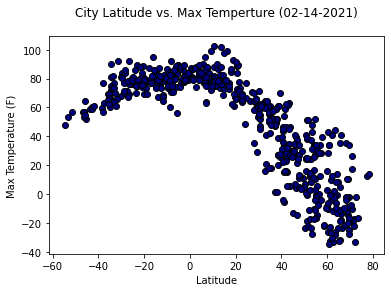

In [9]:
x_values = clean_city_data['Lat']
y_values = clean_city_data['Max Temp']
DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

#plt.ylim(-30,110)
#plt.xlim(-60,90)
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.title("City Latitude vs. Max Temperture ("+str(DT)+")",pad=20)
plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")

plt.savefig("LatitudeVsTemperature")
plt.show


## Latitude vs. Humidity Plot

<function matplotlib.pyplot.show(close=None, block=None)>

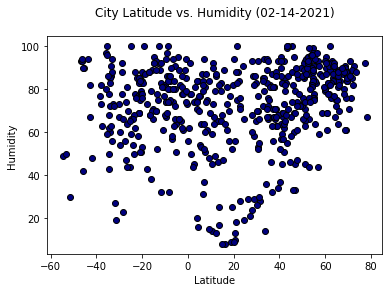

In [10]:
x_values = clean_city_data['Lat']
y_values = clean_city_data['Humidity']
DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

#plt.ylim(40,105)
#plt.xlim(-60,90)
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.title("City Latitude vs. Humidity ("+str(DT)+")",pad=20)
plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")

plt.savefig("LatitudeVsHumidity")
plt.show

## Latitude vs. Cloudiness Plot

<function matplotlib.pyplot.show(close=None, block=None)>

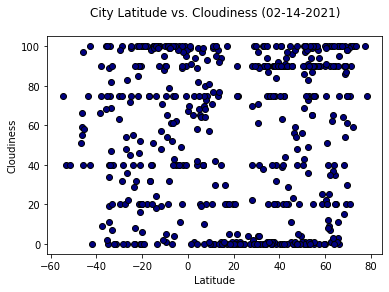

In [11]:
x_values = clean_city_data['Lat']
y_values = clean_city_data['Cloudiness']
DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

#plt.ylim(-5,105)
#plt.xlim(-60,90)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.title("City Latitude vs. Cloudiness ("+str(DT)+")",pad=20)
plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")

plt.savefig("LatitudeVsCloudiness")
plt.show

## Latitude vs. Wind Speed Plot

<function matplotlib.pyplot.show(close=None, block=None)>

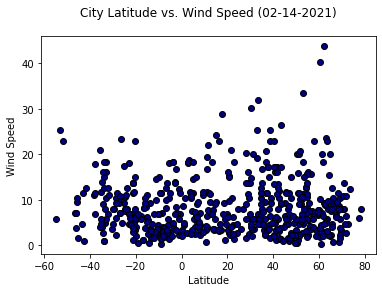

In [13]:
x_values = clean_city_data['Lat']
y_values = clean_city_data['Wind Speed']
DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

#plt.ylim(-5,30)
#plt.xlim(-60,90)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.title("City Latitude vs. Wind Speed ("+str(DT)+")",pad=20)
plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")

plt.savefig("LatitudeVsWind Speed")
plt.show

## Linear Regression

In [14]:
NorthernHemDF = clean_city_data[clean_city_data.Lat >=0]
SouthernHemDF = clean_city_data[clean_city_data.Lat <0]
print("rows in NorthernHemDF = "+str(len(NorthernHemDF)))
print("rows in SouthernHemDF = "+str(len(SouthernHemDF)))

rows in NorthernHemDF = 368
rows in SouthernHemDF = 184


####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.7616057872218417


<function matplotlib.pyplot.show(close=None, block=None)>

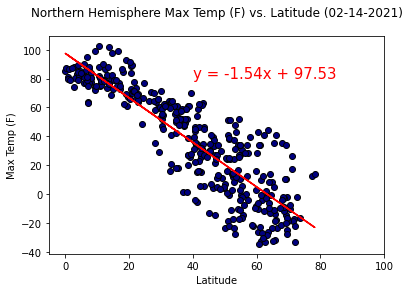

In [38]:
Var = 'Max Temp'
VarLabel = 'Max Temp (F)'
HemLabel = 'Northern Hemisphere'
x_values = NorthernHemDF['Lat'].astype(float)
y_values = NorthernHemDF[Var].astype(float)

DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)

plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(40,80),fontsize=15,color="red")
plt.xlim(-5,100)
plt.xlabel("Latitude")
plt.ylabel(VarLabel)
plt.title(HemLabel+" "+ VarLabel+" vs. Latitude ("+str(DT)+")",pad=20)

plt.savefig(HemLabel+"_LatitudeVs"+Var+"_Regression")
print(f"The r-value is: {rvalue**2}")
plt.show


####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.3879214929534952


<function matplotlib.pyplot.show(close=None, block=None)>

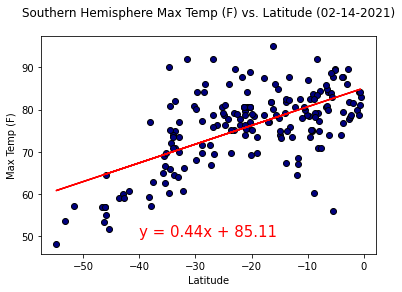

In [30]:
Var = 'Max Temp'
VarLabel = 'Max Temp (F)'
HemLabel = 'Southern Hemisphere'
x_values = SouthernHemDF['Lat'].astype(float)
y_values = SouthernHemDF[Var].astype(float)

DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)

plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-40,50),fontsize=15,color="red")
#plt.xlim(-70,5)
plt.xlabel("Latitude")
plt.ylabel(VarLabel)
plt.title(HemLabel+" "+ VarLabel+" vs. Latitude ("+str(DT)+")",pad=20)

plt.savefig(HemLabel+"_LatitudeVs"+Var+"_Regression")
print(f"The r-value is: {rvalue**2}")
plt.show

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.16215188228011096


<function matplotlib.pyplot.show(close=None, block=None)>

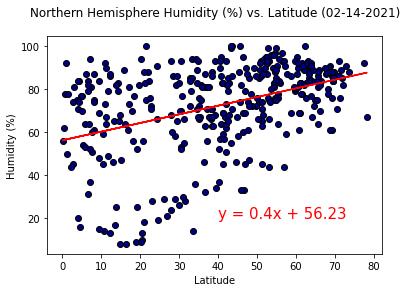

In [31]:
Var = 'Humidity'
VarLabel = 'Humidity (%)'
HemLabel = 'Northern Hemisphere'
x_values = NorthernHemDF['Lat'].astype(float)
y_values = NorthernHemDF[Var].astype(float)

DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)

plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(40,20), fontsize=15,color="red")
#plt.xlim(-5,100)
plt.xlabel("Latitude")
plt.ylabel(VarLabel)
plt.title(HemLabel+" "+ VarLabel+" vs. Latitude ("+str(DT)+")",pad=20)

plt.savefig(HemLabel+"_LatitudeVs"+Var+"_Regression")
print(f"The r-value is: {rvalue**2}")
plt.show

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.023754531984672617


<function matplotlib.pyplot.show(close=None, block=None)>

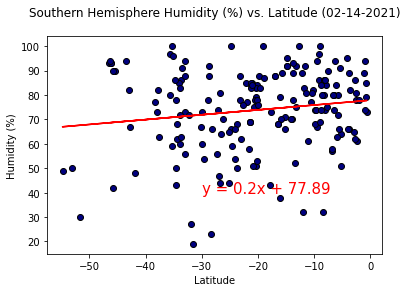

In [32]:
Var = 'Humidity'
VarLabel = 'Humidity (%)'
HemLabel = 'Southern Hemisphere'
x_values = SouthernHemDF['Lat'].astype(float)
y_values = SouthernHemDF[Var].astype(float)

DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)

plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-30,40),fontsize=15,color="red")
#plt.xlim(-70,5)
plt.xlabel("Latitude")
plt.ylabel(VarLabel)
plt.title(HemLabel+" "+ VarLabel+" vs. Latitude ("+str(DT)+")",pad=20)

plt.savefig(HemLabel+"_LatitudeVs"+Var+"_Regression")
print(f"The r-value is: {rvalue**2}")
plt.show

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.027077779062110473


<function matplotlib.pyplot.show(close=None, block=None)>

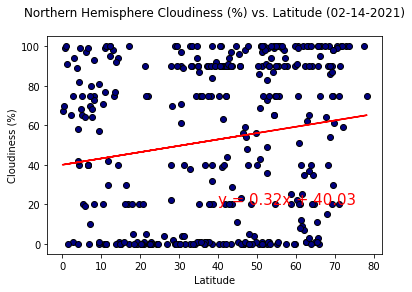

In [33]:
Var = 'Cloudiness'
VarLabel = 'Cloudiness (%)'
HemLabel = 'Northern Hemisphere'
x_values = NorthernHemDF['Lat'].astype(float)
y_values = NorthernHemDF[Var].astype(float)

DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)

plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(40,20),fontsize=15,color="red")
#plt.xlim(-5,100)
plt.xlabel("Latitude")
plt.ylabel(VarLabel)
plt.title(HemLabel+" "+ VarLabel+" vs. Latitude ("+str(DT)+")",pad=20)

plt.savefig(HemLabel+"_LatitudeVs"+Var+"_Regression")
print(f"The r-value is: {rvalue**2}")
plt.show

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.035819712689965005


<function matplotlib.pyplot.show(close=None, block=None)>

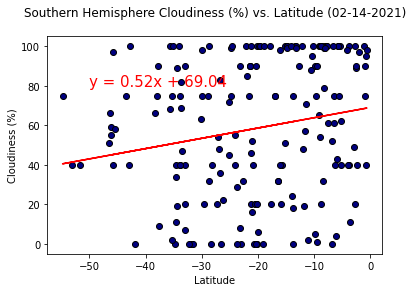

In [34]:
Var = 'Cloudiness'
VarLabel = 'Cloudiness (%)'
HemLabel = 'Southern Hemisphere'
x_values = SouthernHemDF['Lat'].astype(float)
y_values = SouthernHemDF[Var].astype(float)

DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)

plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,80),fontsize=15,color="red")
#plt.xlim(-70,5)
plt.xlabel("Latitude")
plt.ylabel(VarLabel)
plt.title(HemLabel+" "+ VarLabel+" vs. Latitude ("+str(DT)+")",pad=20)

plt.savefig(HemLabel+"_LatitudeVs"+Var+"_Regression")
print(f"The r-value is: {rvalue**2}")
plt.show

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.0005934897615915573


<function matplotlib.pyplot.show(close=None, block=None)>

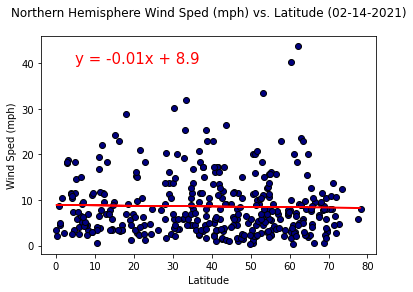

In [36]:
Var = 'Wind Speed'
VarLabel = 'Wind Sped (mph)'
HemLabel = 'Northern Hemisphere'
x_values = NorthernHemDF['Lat'].astype(float)
y_values = NorthernHemDF[Var].astype(float)

DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)

plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5,40),fontsize=15,color="red")
#plt.xlim(-5,100)
plt.xlabel("Latitude")
plt.ylabel(VarLabel)
plt.title(HemLabel+" "+ VarLabel+" vs. Latitude ("+str(DT)+")",pad=20)

plt.savefig(HemLabel+"_LatitudeVs"+Var+"_Regression")
print(f"The r-value is: {rvalue**2}")
plt.show

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.04785363551199965


<function matplotlib.pyplot.show(close=None, block=None)>

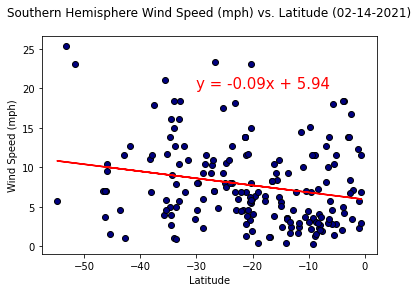

In [37]:
Var = 'Wind Speed'
VarLabel = 'Wind Speed (mph)'
HemLabel = 'Southern Hemisphere'
x_values = SouthernHemDF['Lat'].astype(float)
y_values = SouthernHemDF[Var].astype(float)

DT = datetime.utcfromtimestamp(clean_city_data.loc[0,"Date"]).strftime('%m-%d-%Y')

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.pearsonr(x_values,y_values)

plt.scatter(x_values, y_values, marker="o", facecolors="navy",edgecolors="black")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-30,20),fontsize=15,color="red")
#plt.xlim(-70,5)
plt.xlabel("Latitude")
plt.ylabel(VarLabel)
plt.title(HemLabel+" "+ VarLabel+" vs. Latitude ("+str(DT)+")",pad=20)

plt.savefig(HemLabel+"_LatitudeVs"+Var+"_Regression")
print(f"The r-value is: {rvalue**2}")
plt.show